# 1. Basic operation

In [8]:
from __future__ import print_function
import torch

**doc file** https://pytorch.org/docs/stable/torch.html

In [6]:
x = torch.empty(5, 3)

# a random matrix 
x = torch.rand(5, 3)
# zero matrix
x = torch.zeros(5, 3, dtype=torch.long)
# construct a tensor from data
x = torch.tensor([5.5, 3])
# copy the size
x = x.new_ones(5, 3, dtype=torch.double)      # new_* methods take in sizes
x = torch.randn_like(x, dtype=torch.float)
x.size()

torch.Size([5, 3])

In [8]:
# oprations
y=torch.randn(5,3)
torch.add(x, y)
# save an empty result
result = torch.empty(5, 3)
torch.add(x, y, out=result)

tensor([[ 1.4133, -1.4118, -0.9084],
        [ 0.5822, -0.5884,  0.1504],
        [-1.7354, -1.7094, -0.0556],
        [ 0.6729,  1.1431, -2.8393],
        [-0.6621, -4.6501, -1.9688]])

In [10]:
# oprations with _ will change the origin value
# adds x to y
y.add_(x)
# choose the second column
x[:, 1]

tensor([-1.0980,  0.7095,  0.1127,  0.4104, -2.6791])

In [12]:
# reshape
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)
# change a one dimension tensor to a scaler
x = torch.randn(1)
print(x.item())

0.5147828459739685


In [16]:
# change to numpy 
b = x.numpy()
print(b)
x.add_(1)
print(x)
print(b)

[1.5147829]
tensor([2.5148])
[2.514783]


In [18]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


# 2. Autogrand

`torch.Tensor` is the central class of the package. If you set its attribute .requires_grad as True, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in` with torch.no_grad():`. This can be particularly helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, but for which we don’t need the gradients.

There’s one more class which is very important for autograd implementation - a Function.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a `.grad_fn` attribute that references a Function that has created the Tensor (except for Tensors created by the user - their `grad_fn` is None).

If you want to compute the derivatives, you can call `.backward()` on a Tensor. If Tensor is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to `backward()`, however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

In [33]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

y=x+2
print(y.grad_fn)

z = y * y * 3
out = z.mean()
print(z,out)

a=torch.randn(2,2)
a.requires_grad_(True)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


tensor([[-0.3196,  1.2596],
        [-0.7662, -0.1270]], requires_grad=True)

In [34]:

out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [35]:
with torch.no_grad():
    print((x ** 2).requires_grad)


False


In [37]:
x = torch.ones(2, 2, requires_grad=True)
x.detach_()
print(x.requires_grad)

False


# 3. Neural Network

An `nn.Module` contains layers, and a method `forward(input)`that returns the `output`.


* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Define the network

In [17]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [19]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)
net.zero_grad()
out.backward(torch.randn(1, 10))

tensor([[-0.0147, -0.0227, -0.0650, -0.0062, -0.1208,  0.0253,  0.0686,  0.0053,
         -0.0247,  0.0700]], grad_fn=<AddmmBackward>)


## Loss function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under the nn package . A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

* L1Loss
* MSELoss
* KLDivLoss
* BCELoss


In [20]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9656, grad_fn=<MseLossBackward>)


input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss

In [21]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## Back propagation

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call `loss.backward()`, and have a look at conv1’s bias gradients before and after the backward.

In [22]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0079,  0.0062,  0.0048, -0.0058, -0.0065,  0.0010])


## Update the weights

`weight = weight - learning_rate * gradient`

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: torch.optim that implements all these methods. Using it is very simple:

In [23]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Classifier

We have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, `viz.`, `torchvision.datasets` and `torch.utils.data.DataLoader`.

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data

# 4. The neural network model with minist data
by Chuting Sun

## Load data


In [1]:
import torchvision
import torchvision.transforms as transforms

In [2]:
import numpy as np
import sklearn

In [3]:

from sklearn.datasets import fetch_openml
mnist =fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

In [4]:
y[0]

5

In [5]:
X.shape

(70000, 784)

In [6]:
X[0].shape

(784,)

In [9]:
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset, TensorDataset
np.random.seed(42)
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [60000, 10000])

trainloader = DataLoader(dataset=train_dataset, batch_size=400,shuffle=True,num_workers=2)
valloader = DataLoader(dataset=val_dataset, batch_size=400,shuffle=False,num_workers=2)

## Define the linear and relu layers

In [17]:
class SigNet(nn.Module):
    def __init__(self):
        super(SigNet, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        

    def forward(self, x):
        
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
signet=SigNet()

## Define the loss function

In [19]:
#print(net.state_dict())
#print(signet.state_dict())

lr = 0.001
n_epochs = 1000

criterion = nn.CrossEntropyLoss()
#optimizer1 = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(signet.parameters(), lr=0.001, momentum=0.9)

## Train the model

In [20]:
def get_accuracy(loader):
    total = 0 
    correct=0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = signet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return(100 * correct / total)


In [24]:
train_accuracy = list(0. for i in range(100))
predict_accuracy = list(0. for i in range(100))
loss_function = list(0. for i in range(100))

In [25]:

# for linear model
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = signet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0
    
    train_accuracy[epoch] = get_accuracy(trainloader)
    predict_accuracy[epoch] = get_accuracy(valloader)
    loss_function[epoch] = running_loss /((i+1)*400)
    
    if epoch % 5 == 4:    # print every 100 epoches
        print('[%d] loss: %.8f' % (epoch + 1, loss_function[epoch]))
        print('[%d] train accuracy: %.8f' % (epoch + 1, train_accuracy[epoch]))
        print('[%d] predictive accuracy: %.8f' % (epoch + 1, predict_accuracy[epoch]))

print('Finished Training')
# save the model
PATH = './cifar_net.pth'
torch.save(signet.state_dict(), PATH)

[5] loss: 0.00000913
[5] train accuracy: 99.99000000
[5] predictive accuracy: 97.56000000
[10] loss: 0.00000635
[10] train accuracy: 99.99833333
[10] predictive accuracy: 97.55000000
[15] loss: 0.00000466
[15] train accuracy: 99.99833333
[15] predictive accuracy: 97.57000000
[20] loss: 0.00000364
[20] train accuracy: 99.99833333
[20] predictive accuracy: 97.64000000
[25] loss: 0.00000300
[25] train accuracy: 100.00000000
[25] predictive accuracy: 97.61000000
[30] loss: 0.00000250
[30] train accuracy: 100.00000000
[30] predictive accuracy: 97.63000000
[35] loss: 0.00000215
[35] train accuracy: 100.00000000
[35] predictive accuracy: 97.67000000
[40] loss: 0.00000186
[40] train accuracy: 100.00000000
[40] predictive accuracy: 97.64000000
[45] loss: 0.00000166
[45] train accuracy: 100.00000000
[45] predictive accuracy: 97.64000000
[50] loss: 0.00000147
[50] train accuracy: 100.00000000
[50] predictive accuracy: 97.63000000
[55] loss: 0.00000133
[55] train accuracy: 100.00000000
[55] predic

## Test the model fit

In [26]:
# load back the model
#net = Net()
#net.load_state_dict(torch.load(PATH))

signet = SigNet()
signet.load_state_dict(torch.load(PATH))

#outputs = net(images)
#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              #for j in range(4)))

<All keys matched successfully>

In [35]:
# for signet model
class_total = list(0. for i in range(10))
class_correct = list(0. for i in range(10))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = signet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        # batch size =4
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of classes %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of classes     0 : 100 %
Accuracy of classes     1 : 100 %
Accuracy of classes     2 : 100 %
Accuracy of classes     3 : 100 %
Accuracy of classes     4 : 87 %
Accuracy of classes     5 : 100 %
Accuracy of classes     6 : 90 %
Accuracy of classes     7 : 100 %
Accuracy of classes     8 : 100 %
Accuracy of classes     9 : 81 %


No handles with labels found to put in legend.


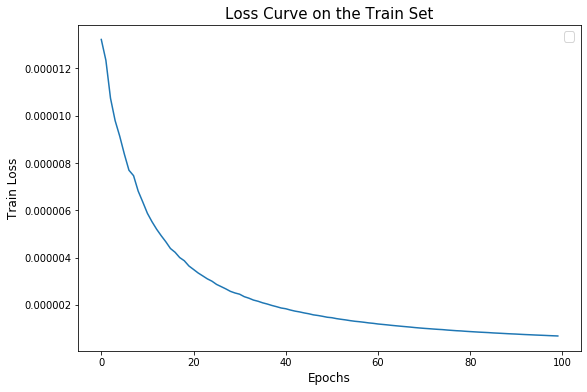

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import mpl

fig,ax = plt.subplots(figsize=(9,6))
ax.plot(loss_function)

title=ax.set_title("Loss Curve on the Train Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Train Loss")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.show()

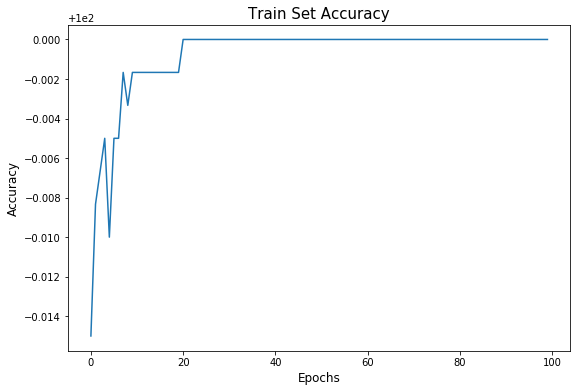

In [34]:
fig,ax = plt.subplots(figsize=(9,6))

ax.plot(train_accuracy)

title=ax.set_title("Train Set Accuracy")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Accuracy")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)

plt.show()

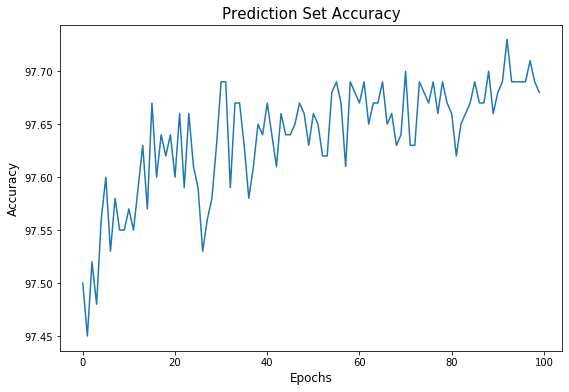

In [32]:
fig,ax = plt.subplots(figsize=(9,6))

ax.plot(predict_accuracy)

title=ax.set_title("Prediction Set Accuracy")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Accuracy")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)

plt.show()